In [1]:
import os
import torch
import numpy as np
import glob
from model import StyledGenerator
import math
import matplotlib.pyplot as plt

C:\conda\envs\face_edit\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 载入模型
netG = StyledGenerator(512)
netG.load_state_dict(torch.load('./checkpoints/stylegan-1024px-new.model',map_location=device)["g_running"], strict=False)
netG.eval()
netG = netG.to(device)

In [3]:
# 遍历Z向量
z_list = glob.glob('./latents/z/*.npy')

In [4]:
z_list

['./latents/z\\fake1.npy', './latents/z\\fake2.npy', './latents/z\\fake3.npy']

In [5]:
# Z 转为 W 向量
for z_item in z_list:
    # 文件名
    filename = z_item.split(os.sep)[-1]
   
    # 加载
    latent = torch.from_numpy(np.load(z_item))
    if len(latent.shape) == 1:
        latent = latent.unsqueeze(0)
    # 转为W向量
    style = netG.style((latent).to(device))
    # 存储
    np.save('./latents/z/related_w/'+filename,style.detach().cpu().numpy()) 

In [6]:
step = int(math.log(1024, 2)) - 2

In [7]:
## 生成图片
def make_image(tensor):
    return (
        tensor.detach()
        .clamp_(min=-1, max=1)
        .add(1)
        .div_(2)
        .mul(255)
        .type(torch.uint8)
        .permute(0, 2, 3, 1)
        .to("cpu")
        .numpy()
    )


# 验证一下
def generateImg(img_name):
    
    # Z
    # 载入人脸向量
    latent = torch.from_numpy(np.load('./latents/z/{}.npy'.format(img_name))).to(device)
    latent = latent.unsqueeze(0)
    # 生成的图片
    img_gen_z = netG([latent], step=step) 
    # 保存图片
    img_ar_z = make_image(img_gen_z)[0]
    

    latent = torch.from_numpy(np.load('./latents/z/related_w/{}.npy'.format(img_name))).to(device)
    #生成结果只由mean_style决定
    img_gen_w = netG([latent], mean_style = latent, step=step, style_weight=0) 
    img_ar_w = make_image(img_gen_w)[0]

    
    
    fig = plt.figure(figsize=(20, 10))

    # 原图
    plt.subplot(1, 2, 1)
    plt.imshow(img_ar_z)
    plt.title('Z')
    plt.axis('off')  
    # 上次合成
    plt.subplot(1, 2, 2)
    plt.imshow(img_ar_w)
    plt.title('W')    
    plt.axis('off')
  

    plt.tight_layout()

    

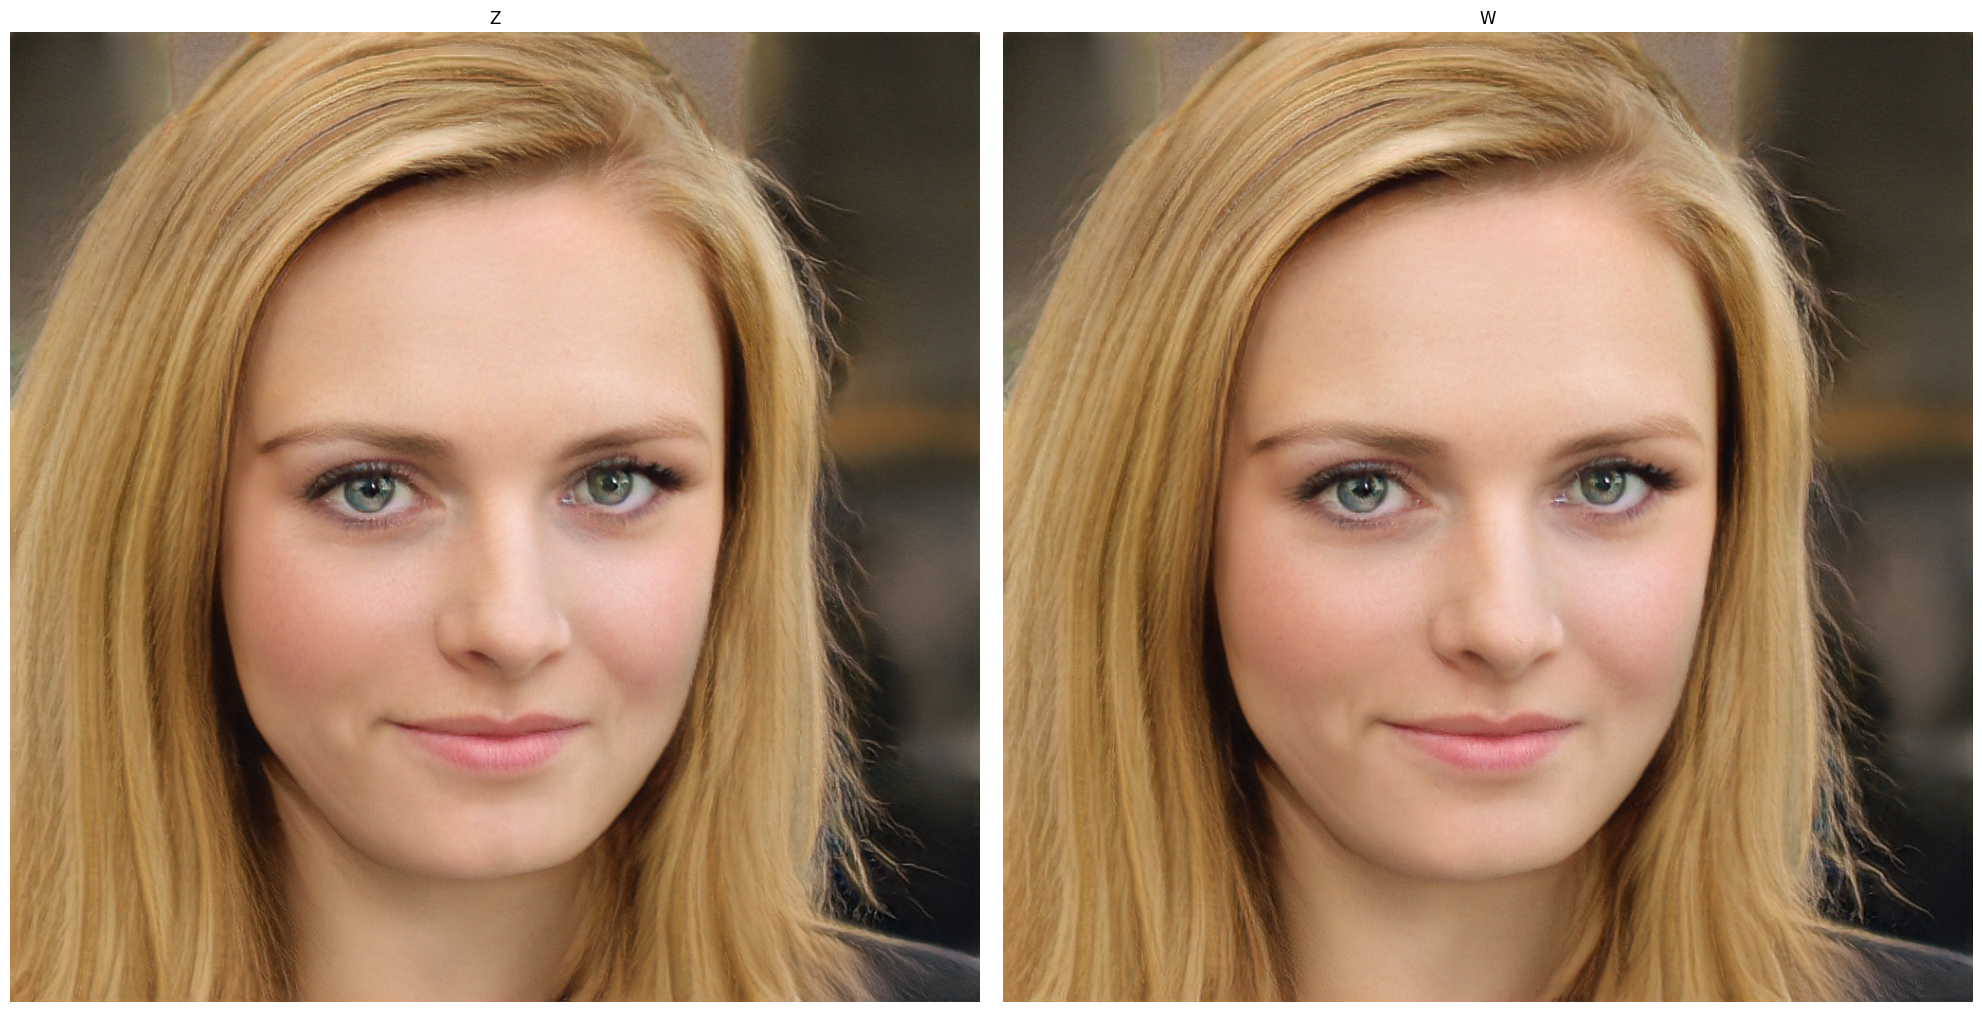

In [10]:
generateImg('fake3')